<a href="https://colab.research.google.com/github/ajinkyajumde/customer-prediction/blob/main/Final_Customer_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [406]:
#importing all the neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from statsmodels.stats.outliers_influence import variance_inflation_factor
from google.colab import drive
from datetime import datetime
import datetime as dt
from imblearn.over_sampling import ADASYN
# Importing XGBoost
from xgboost import XGBClassifier
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
# Importing random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [407]:
#mounting the google drive for importing the csv files uploaded on the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [408]:
#assigning the neccessary path to create a dataframe for the pandas operation
data='/content/drive/MyDrive/Almabetter projects/Customer prediction/train_wn75k28.csv'
test_dataset=pd.read_csv(data)

## **DATA INSPECTION**

In [409]:
test_dataset.head(5)

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0


In [410]:
test_dataset.tail(5)

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
39156,39157,2021-12-31,11,11,2.0,2017-10-19,1,0,0,0,1,1,1,0,0,0,0,0,0
39157,39158,2021-12-31,3,9,3.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
39158,39159,2021-12-31,8,7,2.0,NaN,1,0,0,0,1,0,1,0,0,0,0,0,0
39159,39160,2021-12-31,7,12,2.0,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0
39160,39161,2021-12-31,2,5,NaN,2019-08-11,1,0,0,0,0,0,1,0,0,0,0,0,0


In [411]:
test_dataset.describe()

,id,campaign_var_1,campaign_var_2,products_purchased,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
count,39161.000000,39161.000000,39161.000000,18250.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000
mean,19581.000000,6.523812,6.452746,2.154137,0.400092,0.006716,0.102832,0.011465,0.151503,0.499834,0.286612,0.174434,0.011440,0.000383,0.218942,0.000562,0.051020
std,11304.951283,3.472944,2.614296,0.779815,0.509194,0.081676,0.303743,0.106463,0.359681,0.558166,0.455784,0.379689,0.106346,0.019568,0.431544,0.023696,0.220042
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9791.000000,4.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19581.000000,6.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29371.000000,9.000000,8.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,39161.000000,16.000000,15.000000,4.000000,3.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [412]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    39161 non-null  int64  
 1   created_at            39161 non-null  object 
 2   campaign_var_1        39161 non-null  int64  
 3   campaign_var_2        39161 non-null  int64  
 4   products_purchased    18250 non-null  float64
 5   signup_date           24048 non-null  object 
 6   user_activity_var_1   39161 non-null  int64  
 7   user_activity_var_2   39161 non-null  int64  
 8   user_activity_var_3   39161 non-null  int64  
 9   user_activity_var_4   39161 non-null  int64  
 10  user_activity_var_5   39161 non-null  int64  
 11  user_activity_var_6   39161 non-null  int64  
 12  user_activity_var_7   39161 non-null  int64  
 13  user_activity_var_8   39161 non-null  int64  
 14  user_activity_var_9   39161 non-null  int64  
 15  user_activity_var_1

In [413]:
test_dataset=test_dataset.drop(columns=['signup_date','id'],axis=1)

In [414]:
test_dataset=test_dataset.fillna(0)

In [415]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   created_at            39161 non-null  object 
 1   campaign_var_1        39161 non-null  int64  
 2   campaign_var_2        39161 non-null  int64  
 3   products_purchased    39161 non-null  float64
 4   user_activity_var_1   39161 non-null  int64  
 5   user_activity_var_2   39161 non-null  int64  
 6   user_activity_var_3   39161 non-null  int64  
 7   user_activity_var_4   39161 non-null  int64  
 8   user_activity_var_5   39161 non-null  int64  
 9   user_activity_var_6   39161 non-null  int64  
 10  user_activity_var_7   39161 non-null  int64  
 11  user_activity_var_8   39161 non-null  int64  
 12  user_activity_var_9   39161 non-null  int64  
 13  user_activity_var_10  39161 non-null  int64  
 14  user_activity_var_11  39161 non-null  int64  
 15  user_activity_var_1

In [416]:
test_dataset['buy'].value_counts()

0    37163
1     1998
Name: buy, dtype: int64

In [417]:
for i in list(test_dataset.describe()):
  print(f'The Value count for {i} is','\n')
  print(test_dataset[i].value_counts())

The Value count for campaign_var_1 is 

6     4061
5     4060
4     4018
3     3784
7     3756
2     3486
8     3407
9     2866
10    2392
11    1873
1     1593
12    1455
13    1059
14     714
15     456
16     181
Name: campaign_var_1, dtype: int64
The Value count for campaign_var_2 is 

6     5744
7     5472
5     5250
8     4690
4     4213
9     3537
3     2883
10    2298
2     1788
11    1410
12     761
1      589
13     351
14     151
15      24
Name: campaign_var_2, dtype: int64
The Value count for products_purchased is 

0.0    20911
2.0     8867
3.0     5024
1.0     3643
4.0      716
Name: products_purchased, dtype: int64
The Value count for user_activity_var_1 is 

0    23869
1    14917
2      374
3        1
Name: user_activity_var_1, dtype: int64
The Value count for user_activity_var_2 is 

0    38898
1      263
Name: user_activity_var_2, dtype: int64
The Value count for user_activity_var_3 is 

0    35134
1     4027
Name: user_activity_var_3, dtype: int64
The Value count fo

In [418]:
test_dataset=test_dataset.drop(columns=['user_activity_var_2','user_activity_var_3','user_activity_var_4','user_activity_var_9','user_activity_var_10','user_activity_var_12'],axis=1)

## **EXPLORATORY DATA ANALYSIS**

In [419]:
buyers=test_dataset[test_dataset['buy']==1]
non_buyers=test_dataset[test_dataset['buy']==0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

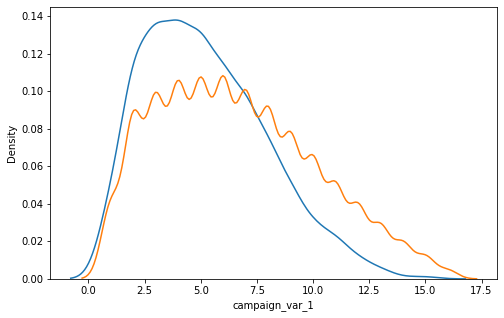

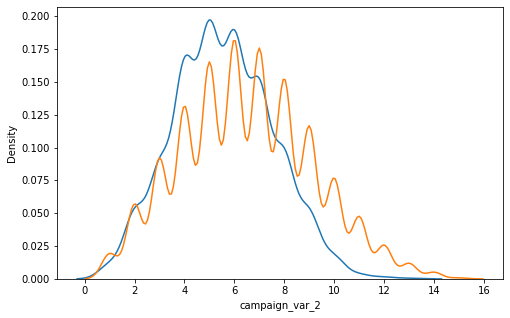

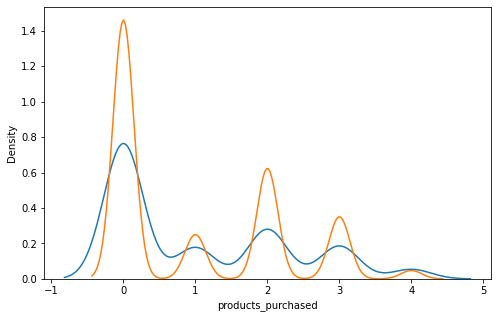

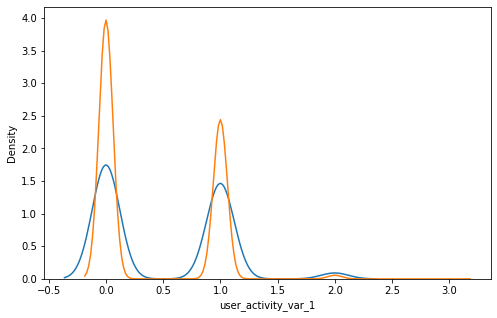

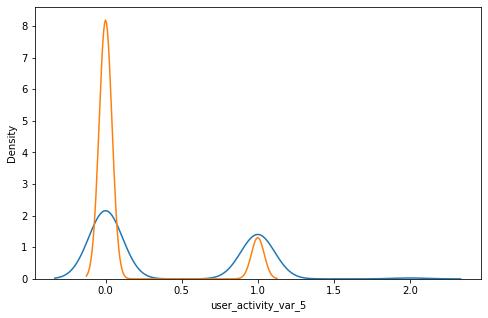

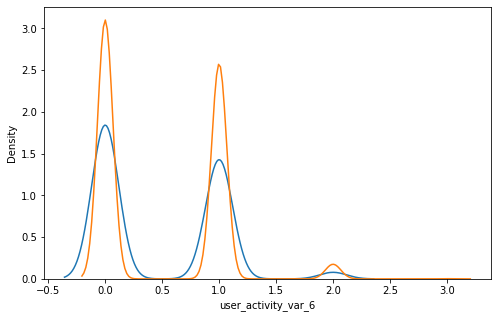

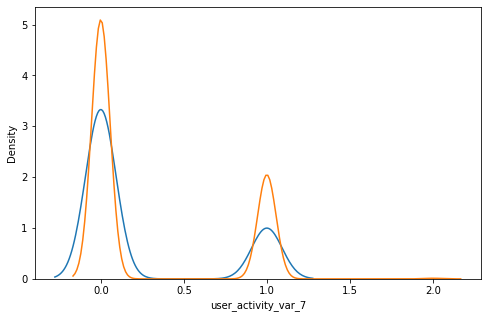

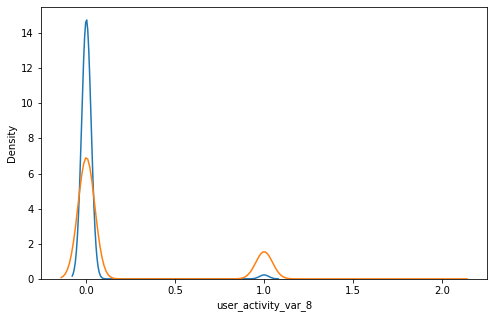

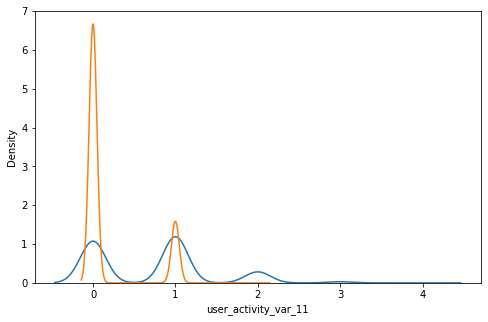

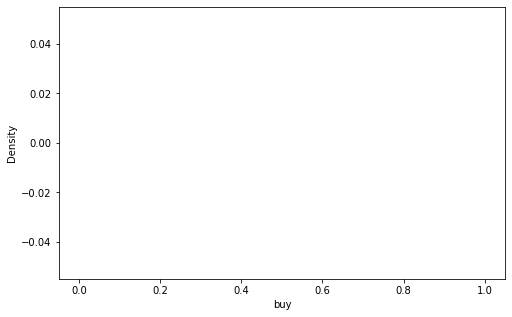

In [420]:
# Distribution plot
for i in list(test_dataset.describe()):
   plt.figure(figsize=(8,5))
   ax = sns.distplot(buyers[i],label='buy',hist=False)
   ax = sns.distplot(non_buyers[i],label='didnt buy',hist=False)
   ax.set(xlabel=i)
plt.show()

In [421]:

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [422]:
calc_vif(test_dataset[[i for i in test_dataset.describe().columns if i not in ['buy']]])

,variables,VIF
0,campaign_var_1,6.435849
1,campaign_var_2,7.938553
2,products_purchased,1.569130
3,user_activity_var_1,1.514679
4,user_activity_var_5,1.152587
5,user_activity_var_6,1.748143
6,user_activity_var_7,1.327191
7,user_activity_var_8,1.167663
8,user_activity_var_11,1.224487


campaign_var_2 is the feature having VIF greater than 5 so we drop it in order to reduce the multi collinearity in the dataset

In [423]:
test_dataset=test_dataset.drop(columns=['campaign_var_2'])

In [424]:
calc_vif(test_dataset[[i for i in test_dataset.describe().columns if i not in ['buy']]])

,variables,VIF
0,campaign_var_1,2.658324
1,products_purchased,1.526388
2,user_activity_var_1,1.478687
3,user_activity_var_5,1.145653
4,user_activity_var_6,1.623772
5,user_activity_var_7,1.285043
6,user_activity_var_8,1.156745
7,user_activity_var_11,1.201268


Here we conclude that the dataset is free from multi collinearity and we can proceed further with the modelling

In [425]:
# splitting "Date" column into three other columns like "year","month","day".
test_dataset['created_at'] = test_dataset['created_at'].apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d"))

In [426]:
test_dataset['year'] = test_dataset['created_at'].dt.year
test_dataset['month'] = test_dataset['created_at'].dt.month
test_dataset['day'] = test_dataset['created_at'].dt.day_name()

In [427]:
test_dataset=test_dataset.drop(columns=['created_at','year'],axis=1)

In [428]:
buyers=test_dataset[test_dataset['buy']==1]
non_buyers=test_dataset[test_dataset['buy']==0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'buy')]

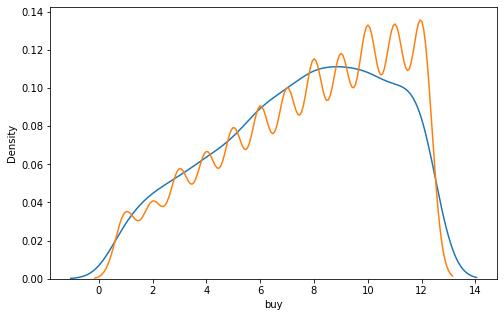

In [429]:
plt.figure(figsize=(8,5))
ax = sns.distplot(buyers['month'],label='buy',hist=False)
ax = sns.distplot(non_buyers['month'],label='didnt buy',hist=False)
ax.set(xlabel=i)

In [430]:
lst=list(test_dataset.columns)
lst

['campaign_var_1',
 'products_purchased',
 'user_activity_var_1',
 'user_activity_var_5',
 'user_activity_var_6',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_11',
 'buy',
 'month',
 'day']

In [431]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   campaign_var_1        39161 non-null  int64  
 1   products_purchased    39161 non-null  float64
 2   user_activity_var_1   39161 non-null  int64  
 3   user_activity_var_5   39161 non-null  int64  
 4   user_activity_var_6   39161 non-null  int64  
 5   user_activity_var_7   39161 non-null  int64  
 6   user_activity_var_8   39161 non-null  int64  
 7   user_activity_var_11  39161 non-null  int64  
 8   buy                   39161 non-null  int64  
 9   month                 39161 non-null  int64  
 10  day                   39161 non-null  object 
dtypes: float64(1), int64(9), object(1)
memory usage: 3.3+ MB


In [432]:
lst=lst.remove('buy')

Here we finalise the list of columns(independent variables) to work with in the model.

In [433]:
test_dataset=pd.get_dummies(test_dataset, columns=['month','day'], prefix=['month','day'])

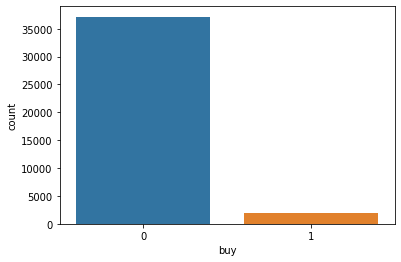

In [434]:
sns.countplot(x=test_dataset['buy'])

Based on the above visualisation it is clear that the given dataset in highly imbalanced in terms of dependent variable. So we proceed with the oversampling technique.

In [435]:
#  # Data for all the independent variables
X = test_dataset.drop(labels='buy',axis=1)

#  # Data for the dependent variable
Y = test_dataset['buy']

In [436]:
test_columns=list(X.columns)
test_columns

['campaign_var_1',
 'products_purchased',
 'user_activity_var_1',
 'user_activity_var_5',
 'user_activity_var_6',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_11',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'day_Friday',
 'day_Monday',
 'day_Saturday',
 'day_Sunday',
 'day_Thursday',
 'day_Tuesday',
 'day_Wednesday']

In [437]:
X.shape, Y.shape

((39161, 27), (39161,))

In [438]:
X.columns

Index(['campaign_var_1', 'products_purchased', 'user_activity_var_1',
       'user_activity_var_5', 'user_activity_var_6', 'user_activity_var_7',
       'user_activity_var_8', 'user_activity_var_11', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'day_Friday',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday'],
      dtype='object')

In [444]:
l=['campaign_var_1', 'products_purchased', 'user_activity_var_1',
       'user_activity_var_5', 'user_activity_var_6', 'user_activity_var_7',
       'user_activity_var_8', 'user_activity_var_11', 'month_1', 'month_2',
       'month_3', 'day_Friday',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday']
X=X[l]

In [445]:
# Train-test split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state=1)

AdaSyn (Adaptive Synthetic Sampling):-
We use this in order to avoid the dominance of high imbalance of the dataset on our model predictions

In [446]:
ada = ADASYN()
X_resampled, y_resampled = ada.fit_resample(X_train, Y_train)

In [447]:
X_train, Y_train=X_resampled, y_resampled

Here we get resampled data out of X train and Y train which is balance and so we will be able to train our model based on this sampled dataset to get highly accurate model.

In [448]:
Y_train.value_counts()

0    29738
1    29529
Name: buy, dtype: int64

In [449]:
# Check the shape of train dataset
print(X_train.shape,Y_train.shape)

# Check the shape of test dataset
print(X_test.shape, Y_test.shape)

(59267, 18) (59267,)
(7833, 18) (7833,)


## **LOGISTIC REGRESSION MODEL WITH K FOLD CROSS VALIDATION**

In [450]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.001,0.05,0.01, 0.1, 1, 10, 100]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.05, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [451]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.256377,0.019529,0.007611,0.002146,0.001,{'C': 0.001},0.804481,0.812291,0.810076,0.815882,...,0.810111,0.003872,7,0.811389,0.809570,0.810942,0.808954,0.810824,0.810336,0.000918
1,0.606365,0.039701,0.006481,0.000032,0.05,{'C': 0.05},0.847640,0.854977,0.850068,0.858556,...,0.851945,0.004170,5,0.853192,0.851387,0.852820,0.850667,0.853154,0.852244,0.001028
2,0.519880,0.063438,0.006537,0.000103,0.01,{'C': 0.01},0.836933,0.844509,0.840375,0.848084,...,0.841724,0.004050,6,0.842963,0.841154,0.842487,0.840504,0.842851,0.841992,0.000984
3,0.637308,0.014278,0.006492,0.000022,0.1,{'C': 0.1},0.849531,0.856649,0.851509,0.860232,...,0.853582,0.004177,4,0.854771,0.852982,0.854446,0.852257,0.854866,0.853864,0.001051
4,0.650616,0.016414,0.006485,0.000027,1,{'C': 1},0.851253,0.858034,0.852101,0.861459,...,0.854762,0.004228,1,0.855997,0.854216,0.854917,0.853495,0.856104,0.854946,0.001008
5,0.662900,0.036693,0.006565,0.000096,10,{'C': 10},0.851020,0.857623,0.852568,0.861508,...,0.854711,0.004193,2,0.855812,0.853923,0.855714,0.853538,0.855939,0.854985,0.001034
6,0.651953,0.021873,0.006452,0.000021,100,{'C': 100},0.851387,0.857125,0.852048,0.861516,...,0.854351,0.004358,3,0.856068,0.853696,0.855072,0.853648,0.854983,0.854693,0.000917


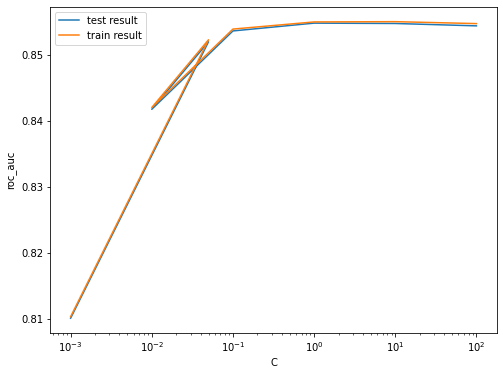

In [452]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [453]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.854762376085907 at C = 1


In [ ]:
# Instantiate the model with best C
logistic_imb = LogisticRegression(C=1)

In [ ]:
# Fit the model on the train set
logistic_imb_model = logistic_imb.fit(X_train, Y_train)

In [ ]:
# Predictions on the train set
Y_train_pred = logistic_imb_model.predict(X_train)

In [ ]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_train, Y_train_pred)
print(confusion)

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [ ]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_train, Y_train_pred))

In [ ]:
# Predictions on the train set
Y_test_pred = logistic_imb_model.predict(X_test)

In [ ]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_test, Y_test_pred)
print(confusion)

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [ ]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_test, Y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_test, Y_test_pred))

## **RANDOM FOREST**

In [464]:
param_grid = {
    'max_depth': range(5,10,5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'n_estimators': [100,200,300], 
    
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
)

# Fit the model
grid_search.fit(X_train, Y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(5, 10, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': [100, 200, 300]})

In [465]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.7407329204041905 using {'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 100, 'n_estimators': 200}


In [469]:
# model with the best hyperparameters

rfc_imb_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             
                             n_estimators=100)

In [470]:
# Fit the model
rfc_imb_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50)

In [471]:
# Predictions on the train set
Y_train_pred = rfc_imb_model.predict(X_train)

In [472]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_train, Y_train_pred)
print(confusion)

[[21020  8718]
 [ 6394 23135]]


In [473]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [474]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_train, Y_train_pred))

Accuracy:- 0.7450183069836502
Sensitivity:- 0.7834671001388466
Specificity:- 0.706839733674087
F1-Score:- 0.753804046788961


In [475]:
# Predictions on the train set
Y_test_pred = rfc_imb_model.predict(X_test)

In [476]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_test, Y_test_pred)
print(confusion)

[[5230 2195]
 [ 105  303]]


In [477]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [478]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_test, Y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_test, Y_test_pred))

Accuracy:- 0.7063704838503766
Sensitivity:- 0.7426470588235294
Specificity:- 0.7043771043771043
F1-Score:- 0.20853406744666206


## **KNN MODEL**

In [ ]:


#Setup arrays to store training and test accuracies
neighbors = np.array([2,5,10,20])
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, Y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, Y_train)
    
    # Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, Y_test) 

In [ ]:
# Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=2)

In [ ]:
# Fit the model
kn_model=knn.fit(X_train,Y_train)

In [ ]:
# Predictions on the train set
Y_train_pred = kn_model.predict(X_train)

In [ ]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_train, Y_train_pred)
print(confusion)

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [ ]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_train, Y_train_pred))

In [ ]:
# Predictions on the train set
Y_test_pred = kn_model.predict(X_test)

In [ ]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_test, Y_test_pred)
print(confusion)

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [ ]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_test, Y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_test, Y_test_pred))

## **XGBOOST ALGORITHM**

In [ ]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.01,0.1,0.5,1,10,50], 
             'subsample': [0.3, 0.6, 0.9,1]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, Y_train) 

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.01,0.1,0.5,1,10], 
             'subsample': [0.3, 0.6, 0.9,1]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [ ]:
model_cv.best_params_

In [ ]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for calculating auc
params = {'learning_rate': 1,
           
          
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
xgb_imb_model = XGBClassifier(params = params)
xgb_imb_model.fit(X_train, Y_train)

In [ ]:
# Predictions on the train set
Y_train_pred = xgb_imb_model.predict(X_train)

In [ ]:
# Confusion matrix
confusion = confusion_matrix(Y_train, Y_train_pred)
print(confusion)


In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [ ]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_train, Y_train_pred))

In [ ]:
Y_test_pred = xgb_imb_model.predict(X_test)

In [ ]:
# Confusion matrix
confusion = confusion_matrix(Y_test, Y_test_pred)
print(confusion)


In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [ ]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_test, Y_test_pred))

## **PREDICTING ON THE GIVEN DATASET**

We use XGB Model for predicting on the given dataset as it has higher accuracy as compared to other models.

In [ ]:
data='/content/drive/MyDrive/Almabetter projects/Customer prediction/test_Wf7sxXF.csv'
test_dataset=pd.read_csv(data)

In [ ]:
test_dataset

In [ ]:
index=test_dataset['id'].tolist()

In [ ]:
index

In [ ]:

lst=['campaign_var_1',
 'products_purchased',
 'user_activity_var_1',
 'user_activity_var_5',
 'user_activity_var_6',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_11','month','day']

In [ ]:
# splitting "Date" column into three other columns like "year","month","day".
test_dataset['created_at'] = test_dataset['created_at'].apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d"))

In [ ]:
test_dataset['year'] = test_dataset['created_at'].dt.year
test_dataset['month'] = test_dataset['created_at'].dt.month
test_dataset['day'] = test_dataset['created_at'].dt.day_name()

In [ ]:
test_dataset=test_dataset[lst]

In [ ]:
test_dataset=pd.get_dummies(test_dataset, columns=['month','day'], prefix=['month','day'])

In [ ]:
test_dataset.head()

In [ ]:
test_dataset.shape

In [ ]:
lst=list(test_dataset.columns)
lst

In [ ]:
# Predictions on the train set
Y_train_pred = xgb_imb_model.predict(test_dataset)